📚 **Theory Overview**

Fourier Transform helps analyze **frequency components** of an image.

- **2D Discrete Fourier Transform (DFT)** is used for image processing.
- **FFT (Fast Fourier Transform)** is a fast algorithm to compute DFT efficiently.

### 🔑 Key Insight:
- **Sharp changes** (e.g. edges, noise) ⟶ **High Frequency**
- **Smooth regions** ⟶ **Low Frequency**

An image can be thought of as a **2D signal**.  
By applying DFT along both the **X** and **Y** axes, we obtain its **frequency representation**.


### 🔧 Using NumPy: Frequency Transform

#### Thresholding

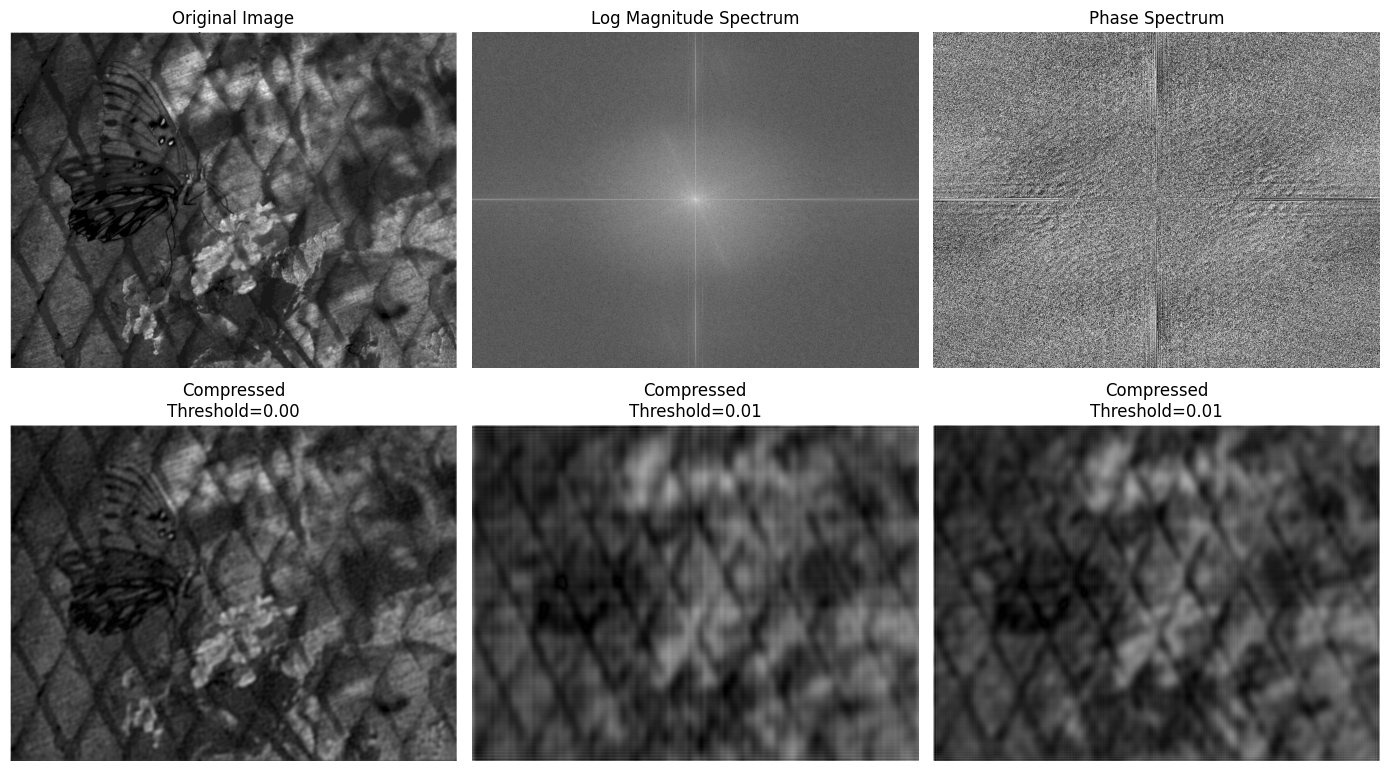

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread(r'D:\Gitrepo\CPV\IMG_1.png', cv.IMREAD_GRAYSCALE)
assert img is not None

# Step 1: FFT (frequency domain)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)

# Step 2: Extract magnitude and phase
magnitude = np.abs(fshift)
phase = np.angle(fshift)

# Step 3: Use three thresholds for (2,3) grid
threshold_list = [0.001, 0.0075, 0.005]  # as fractions of max(magnitude)

plt.figure(figsize=(14, 8))

# (row 1, col 1): Original image
plt.subplot(2, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# (row 1, col 2): Log Magnitude Spectrum
plt.subplot(2, 3, 2)
plt.imshow(np.log1p(magnitude), cmap='gray')
plt.title('Log Magnitude Spectrum')
plt.axis('off')

# (row 1, col 3): Empty or you can show the phase spectrum
plt.subplot(2, 3, 3)
plt.imshow(phase, cmap='gray')
plt.title('Phase Spectrum')
plt.axis('off')

# Row 2: Compressed images for each threshold
for idx, frac in enumerate(threshold_list):
    threshold = frac * np.max(magnitude)
    mask = magnitude > threshold
    fshift_compressed = fshift * mask

    # Step 4: Reconstruct image using IFFT
    f_ishift = np.fft.ifftshift(fshift_compressed)
    img_compressed = np.fft.ifft2(f_ishift)
    img_compressed = np.abs(img_compressed)
    img_compressed = np.clip(img_compressed, 0, 255).astype(np.uint8)

    plt.subplot(2, 3, idx+4)
    plt.imshow(img_compressed, cmap='gray')
    plt.title(f'Compressed\nThreshold={frac:.2f}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### 🚧 High Pass Filtering (HPF)

Remove low-frequency content:

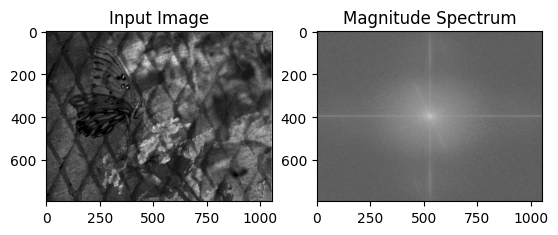

In [3]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread(r'D:\Gitrepo\CPV\IMG_1.png', cv.IMREAD_GRAYSCALE)
assert img is not None

# Compute FFT
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)  # shift zero frequency to center
magnitude_spectrum = 20 * np.log(np.abs(fshift))

# Visualization
plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Input Image')
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray'), plt.title('Magnitude Spectrum')
plt.show()


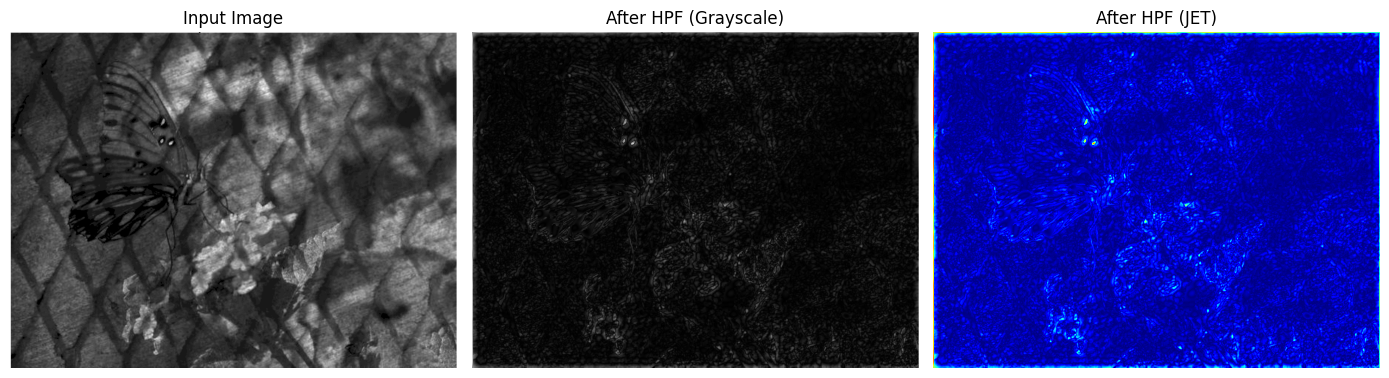

In [4]:
# High Pass Filter (HPF)

rows, cols = img.shape
crow, ccol = rows // 2, cols // 2

# Create a mask with zeros in the center (low frequencies) and ones elsewhere (high frequencies)
mask = np.ones((rows, cols), np.uint8)
mask[crow-30:crow+31, ccol-30:ccol+31] = 0

# Apply mask to the shifted FFT
fshift_hpf = fshift * mask

# Inverse FFT to get the filtered image
f_ishift = np.fft.ifftshift(fshift_hpf)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
img_back = np.clip(img_back, 0, 255)

# Visualization
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_back, cmap='gray')
plt.title('After HPF (Grayscale)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_back, cmap='jet')
plt.title('After HPF (JET)')
plt.axis('off')

plt.tight_layout()
plt.show()

HPF works like an **edge detector** (similar to Sobel, Laplacian, etc.).

⚠️ **Ringing Artifacts**
    
- Caused by sharp mask edges
- Sinc-shaped side lobes appear $\rightarrow$ Visual ripples
- Better to use Gaussian masks instead of rectangular ones

### 🔧 Fourier Transform with OpenCV

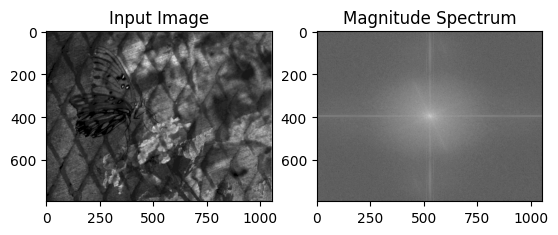

In [6]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread(r'D:\Gitrepo\CPV\IMG_1.png', cv.IMREAD_GRAYSCALE)
assert img is not None

# Compute DFT
dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# Compute magnitude
magnitude_spectrum = 20 * np.log(cv.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]))

plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Input Image')
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray'), plt.title('Magnitude Spectrum')
plt.show()

* Alternatively, use `cv.cartToPolar()` for magnitude & phase directly.

### 🌊 Low Pass Filtering (LPF)

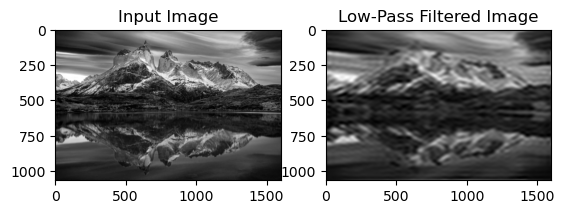

In [19]:
# Low-Pass Filter (LPF)

# shape of the image
rows, cols = img.shape
crow, ccol = rows//2, cols//2

# Create low-pass mask
mask = np.zeros((rows, cols, 2), np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1

# Apply mask & inverse DFT
fshift = dft_shift * mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[:,:,0], img_back[:,:,1])

plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Input Image')
plt.subplot(122), plt.imshow(img_back, cmap='gray'), plt.title('Low-Pass Filtered Image')
plt.show()


### ❓ Why Laplacian & Sobel Are High-Pass Filters?

Let’s visualize their frequency responses:

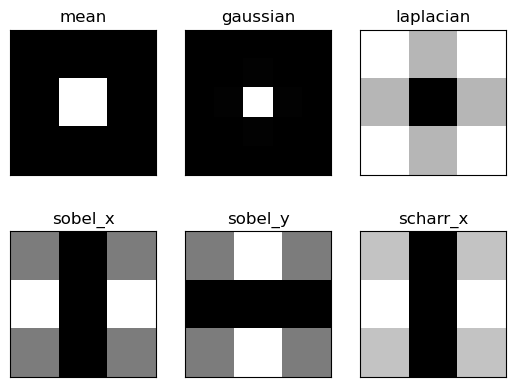

In [ ]:
filters = [
    np.ones((3,3)),  # mean
    cv.getGaussianKernel(5,10) @ cv.getGaussianKernel(5,10).T,  # gaussian
    np.array([[0,1,0], [1,-4,1], [0,1,0]]),  # laplacian
    np.array([[-1,0,1], [-2,0,2], [-1,0,1]]),  # sobel_x
    np.array([[-1,-2,-1], [0,0,0], [1,2,1]]),  # sobel_y
    np.array([[-3,0,3], [-10,0,10], [-3,0,3]])  # scharr
]

names = ['mean', 'gaussian', 'laplacian', 'sobel_x', 'sobel_y', 'scharr_x']
fft_spectra = [np.log(np.abs(np.fft.fftshift(np.fft.fft2(f))) + 1) for f in filters]

for i, mag in enumerate(fft_spectra):
    plt.subplot(2,3,i+1), plt.imshow(mag, cmap='gray')
    plt.title(names[i]), plt.xticks([]), plt.yticks([])

plt.show()

HPFs (like Laplacian) emphasize high-frequency regions (edges). LPFs (like Gaussian) allow low frequencies.